In [1]:
import librosa
import tensorflow as tf
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import Conv1D,Conv2D,Conv3D,Flatten,MaxPool2D,Dense,Softmax,BatchNormalization
import librosa.display
import os
import pandas as pd
import numpy as np
from time import time 
import random as rd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import threading
from sklearn.metrics import confusion_matrix,accuracy_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

path_to_db_voice = "D:\\Utilisateurs\\ENAC\\projet_AIRBUS\\db\\voice\\"
path_to_db_plane = "D:\\Utilisateurs\\ENAC\\projet_AIRBUS\\db\\plane\\"
path_to_db_both = "D:\\Utilisateurs\\ENAC\\projet_AIRBUS\\db\\both\\"

l_voice_records = os.listdir(path_to_db_voice)
l_airplane_records = os.listdir(path_to_db_plane)
l_both_records = os.listdir(path_to_db_both)

In [2]:
#coupe le set en train/test en se basant sur le ratio test_size d'enregistrements que l'on veut pour le set de test
def separe_train_test(db_folder_path,n_records,test_size):
    l_records = os.listdir(db_folder_path)
    sub_l_records = rd.sample(l_records,n_records)
    size = len(sub_l_records)
    sep = round(test_size*size)
    sample = rd.sample(sub_l_records,size)
    test = sample[:sep]
    train = sample[sep:]
    return train,test

In [6]:
def gen_X_train_test(db_folder_path,n_records,test_size):
    sp_rec_train = []
    sp_rec_test = []
    records_train,records_test = separe_train_test(db_folder_path,n_records,test_size)
    i = 0
    for record in records_train:
        print('Building train {}/{}'.format(i,len(records_train)),end='\r')
        #on load l'audio du type voulu
        signal,sample_rate = librosa.load(db_folder_path + record)
        #on fait une STFT
        spectrum = librosa.stft(y=signal,center=True) 
        spectrum = spectrum.astype(float)
        #si jamais l'enregistrement fait moins de 2.3sec on ne le traite pas
        if spectrum.shape[1]>=100:
            n_morceaux = spectrum.shape[1]//100 # pour avoir des pas de 2.3s
            sub_spectrums = [librosa.amplitude_to_db(spectrum[:,j*100:(j+1)*100]) for j in range(n_morceaux)]
            sp_rec_train += sub_spectrums
        i+=1
    i=0
    for record in records_test: 
        print('Building  test {}/{}'.format(i,len(records_test)),end='\r')
        signal,sample_rate = librosa.load(db_folder_path + record)
        spectrum = librosa.stft(y=signal,center=True) 
        spectrum = spectrum.astype(float)
        if spectrum.shape[1]>=100:
            n_morceaux = spectrum.shape[1]//100 # pour avoir des pas de 2.3s
            sub_spectrums = [librosa.amplitude_to_db(spectrum[:,j*100:(j+1)*100]) for j in range(n_morceaux)]
            sp_rec_test += sub_spectrums
            i+=1
    return np.array(sp_rec_train),np.array(sp_rec_test)

In [20]:
# n_records = 500

# X_voice_train,X_voice_test= gen_X_train_test(path_to_db_voice,n_records,0.2)
# print('Voice done',end='\r')
# X_plane_train,X_plane_test = gen_X_train_test(path_to_db_plane,n_records,0.2)
# print('Plane done',end='\r')
# X_both_train,X_both_test = gen_X_train_test(path_to_db_both,n_records,0.2)
# print('Both done',end='\r')

In [21]:
# only_voice = 1
# only_plane = 0
# both_classes = 1

# y_voice_train = np.array([only_voice for elt in X_voice_train])
# y_plane_train = np.array([only_plane for elt in X_plane_train])
# y_both_train = np.array([both_classes for elt in X_both_train])

# y_voice_test = np.array([only_voice for elt in X_voice_test] )
# y_plane_test = np.array([only_plane for elt in X_plane_test])
y_both_test = np.array([both_classes for elt in X_both_test])

# X_train_planeboth = np.concatenate([X_plane_train , X_both_train])
# X_test = np.concatenate([X_plane_test , X_both_test])

# y_train = np.concatenate([y_voice_train , y_plane_train , y_both_train])
# y_test =np.concatenate([y_plane_test , y_both_test])

In [25]:
#pour eviter de generer plein de fois des train/test on les save 

with open('npy/X_train_3_voice.npy','wb') as f:
    np.save(f,X_voice_train)

with open('npy/X_train_3_plane.npy','wb') as f:
    np.save(f,X_plane_train)

with open('npy/X_train_3_both.npy','wb') as f:
    np.save(f,X_both_train)

with open('npy/X_test_3_voice.npy','wb') as f:
    np.save(f,X_voice_test)

with open('npy/X_test_3_plane.npy','wb') as f:
    np.save(f,X_plane_test)

with open('npy/X_test_3_both.npy','wb') as f:
    np.save(f,X_both_test)

with open('npy/y_train_3_voice.npy','wb') as f:
    np.save(f,y_voice_train)

with open('npy/y_train_3_plane.npy','wb') as f:
    np.save(f,y_plane_train)

with open('npy/y_train_3_both.npy','wb') as f:
    np.save(f,y_both_train)

with open('npy/y_test_3_voice.npy','wb') as f:
    np.save(f,y_voice_test)

with open('npy/y_test_3_plane.npy','wb') as f:
    np.save(f,y_plane_test)

with open('npy/y_test_3_both.npy','wb') as f:
    np.save(f,y_both_test)

In [3]:
with open('npy/X_train_3_voice.npy','rb') as f:
    X_voice_train = np.load(f)

with open('npy/X_train_3_plane.npy','rb') as f:
    X_plane_train = np.load(f)

with open('npy/X_train_3_both.npy','rb') as f:
    X_both_train = np.load(f)

with open('npy/X_test_3_voice.npy','rb') as f:
    X_voice_test = np.load(f)

with open('npy/X_test_3_plane.npy','rb') as f:
    X_plane_test = np.load(f)

with open('npy/X_test_3_both.npy','rb') as f:
    X_both_test = np.load(f)

with open('npy/y_train_3_voice.npy','rb') as f:
    y_voice_train =np.load(f)

with open('npy/y_train_3_plane.npy','rb') as f:
    y_plane_train = np.load(f)

with open('npy/y_train_3_both.npy','rb') as f:
    y_both_train = np.load(f)

with open('npy/y_test_3_voice.npy','rb') as f:
    y_voice_test = np.load(f)

with open('npy/y_test_3_plane.npy','rb') as f:
    y_plane_test = np.load(f)

with open('npy/y_test_3_both.npy','rb') as f:
    y_both_test = np.load(f)

In [4]:
X_train = np.concatenate([X_plane_train , X_both_train])
X_test = np.concatenate([X_plane_test , X_both_test])

y_train = np.concatenate([y_plane_train , y_both_train])
y_test =np.concatenate([y_plane_test , y_both_test])

In [4]:
X_train.shape

(3610, 1025, 100)

In [8]:
X_test.shape

(911, 1025, 100)

PARTIE MODELE

In [4]:
freq_range,t_range = X_train[0].shape

input_shape = (freq_range,t_range,1)
inputS = Input(shape=(input_shape),name='main_input')

#modele

y = BatchNormalization()(inputS)
y = Conv2D(16, 1, activation='relu', input_shape=(input_shape))(inputS)
y = MaxPool2D()(y)
y = Flatten()(y)
y = Dense(16)(y)
y = Dense(1,activation='sigmoid')(y)


model = Model(inputs=[inputS],outputs =y)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

model.fit(X_train,y_train,batch_size=64,epochs=10,verbose=1)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 1025, 100, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1025, 100, 16)     32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 50, 16)       0         
_________________________________________________________________
flatten (Flatten)            (None, 409600)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                6553616   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 6,553,665
Trainable params: 6,553,665
Non-trainable params: 0
___________________________________________________

KeyboardInterrupt: 

In [6]:
pred = model.predict(X_test)
pred_round = np.around(pred)
print('Accuracy :',accuracy_score(pred_round,y_test))

Accuracy : 0.9077936333699231


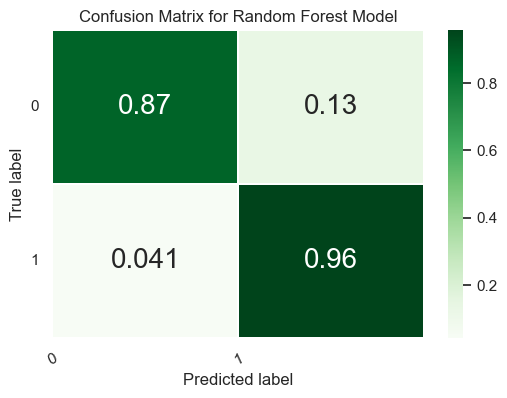

In [7]:
from sklearn.metrics import confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

matrix = confusion_matrix(pred_round,y_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = [0,1]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [8]:
model.save('Conv2D_3.h5')

TEST DU MODELE SAVED

In [2]:
with open('npy/X_test_2.npy','rb') as f:
    X_test = np.load(f)

with open('npy/y_test_2.npy','rb') as f:
    y_test = np.load(f)

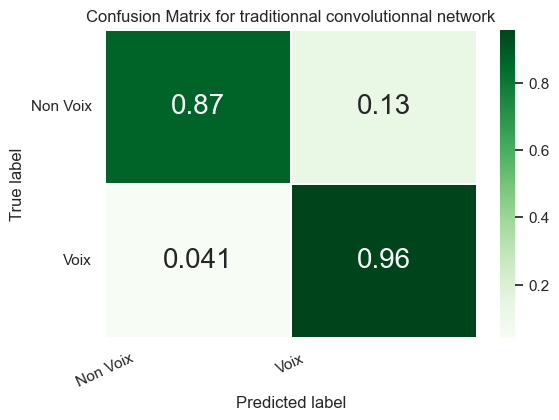

In [6]:
from tensorflow.keras.models import load_model

conv3 = load_model('Conv2D_3.h5')
from sklearn.metrics import confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

pred_conv_3 = np.around(conv3.predict(X_test)) 
matrix = confusion_matrix(pred_conv_3,y_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Non Voix','Voix']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for traditionnal convolutionnal network')
plt.show()

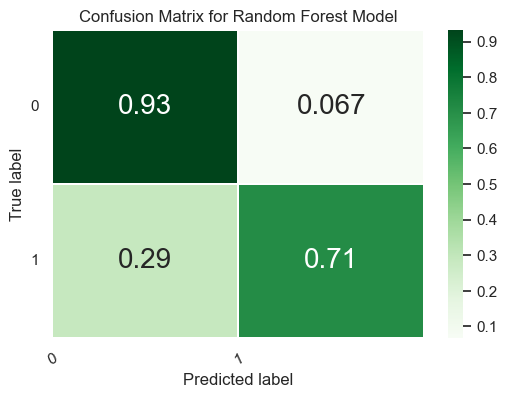

In [19]:
from sklearn.metrics import confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

pred_conv_1 = np.around(conv1.predict(X_test)) 
pred_conv_2 = np.around(conv2.predict(X_test)) 
matrix = confusion_matrix(pred_conv_2,y_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = [0,1]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

TEST MODEL

In [40]:
pred = model.predict(X_test)
pred_round = np.around(pred)
pred_bin = pred_round.astype(int)

print('Accuracy :',accuracy_score(pred_bin,y_test))

Accuracy : 0.6241379310344828


In [ ]:
X_test.shape

(290, 1025, 100)

In [41]:
X_plane_test = X_test[y_test==0]
y_plane_test = y_test[y_test==0]

pred = model.predict(X_plane_test)
pred_round = np.around(pred)
pred_bin = pred_round.astype(int)
print('Accuracy for only planes : ',accuracy_score(pred_bin,y_plane_test))

Accuracy for only planes :  1.0


In [42]:
X_both_test = X_test[y_test==1]
y_both_test = y_test[y_test==1]

pred = model.predict(X_both_test)
pred_round = np.around(pred)
pred_bin = pred_round.astype(int)
print('Accuracy for voice + plane : ',accuracy_score(pred_bin,y_both_test))

Accuracy for voice + plane :  0.2158273381294964
